In [1]:
import pandas as pd
import seaborn as sns; sns.set(); 
pd.options.mode.chained_assignment = None

### Read In Data and Get Needed Cols

In [2]:
config = {
    'county_path' : 'https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv', 
    'state_path'  : 'https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-states.csv', 
    'us_path'     : 'https://raw.githubusercontent.com/nytimes/covid-19-data/master/us.csv'
}

In [3]:
county_df = pd.read_csv(config['county_path']).drop('fips', axis = 1)
state_df = pd.read_csv(config['state_path']).drop('fips', axis = 1)
us_df = pd.read_csv(config['us_path'])

In [4]:
# rename columns to better for an easier way to combine
county_df = county_df.rename(
    columns = {'cases': 'county_cases', 'deaths' : 'county_deaths'}
)

state_df = state_df.rename(
    columns = {'cases': 'state_cases', 'deaths' : 'state_deaths'}
)

us_df = us_df.rename(
    columns = {'cases': 'us_cases', 'deaths' : 'us_deaths'}
)

### Join all Dataframes together

In [5]:
df = county_df.merge(
    right = state_df, 
    how = 'left', 
    on = ['state', 'date']
).merge(
    right = us_df, 
    how = 'left', 
    on = ['date']
)

In [6]:
# reorder the columns to what you need
order = [
    'date', 'county', 'state', 'county_cases', 'state_cases', 
    'us_cases', 'county_deaths', 'state_deaths', 'us_deaths'
]

df = df[order]

# turn the date into datetime
df['date'] = pd.to_datetime(df['date'])

In [7]:
df.sample(5).head()

,date,county,state,county_cases,state_cases,us_cases,county_deaths,state_deaths,us_deaths
53084,2020-04-12,Hampton,South Carolina,7,3319,558249,0,82,24849
11522,2020-03-25,Cass,Minnesota,1,289,68572,0,1,1054
4881,2020-03-19,Ontario,New York,1,4161,12393,0,39,212
94934,2020-04-27,Weber,Utah,139,4236,994110,2,41,56022
105866,2020-05-01,Greene,Pennsylvania,26,49764,1109601,0,2671,64902


### Make a Graph For Growth by State

In [8]:
def get_top_n(df, state, n): 
    dt = county_df['date'].max()
    rank_df = df.loc[df['state'] == state].loc[df['date'] == dt]
    rank_df['rank'] = rank_df['county_cases'].rank(method = 'dense', ascending = False)
    return rank_df.loc[rank_df['rank'] <= n]['county'].tolist()

In [9]:
from datetime import timedelta
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()

def plot_county(state, specifc_counties = [], log = False, n = 5): 
    counties = get_top_n(df = df, state = state, n = n)
    plt.figure(figsize = (15,8))
    county_df = df.loc[
        df['state'] == state
    ].loc[
        df['county'].isin(counties + specifc_counties)
    ]
    end_dt = county_df['date'].max()
    start_dt = pd.to_datetime('2020-03-10')
    
    plot = sns.lineplot(
        x = 'date', 
        y = 'county_cases',
        hue = 'county', 
        data = county_df, 
        
    )
    clean_counties = ','.join(counties)
    dates = pd.date_range(start = start_dt, end = end_dt, freq = '5D').date
    plot.set_xticks(dates)
    plot.set_xticklabels(dates, rotation = 90)
    
    if log: 
        plot.set_yscale('log')
    else:
        pass

    plot.set_title(
        label = 'COVID Growth in {} as of {}'.format(clean_counties, end_dt.date())
    )
    plt.show(); 

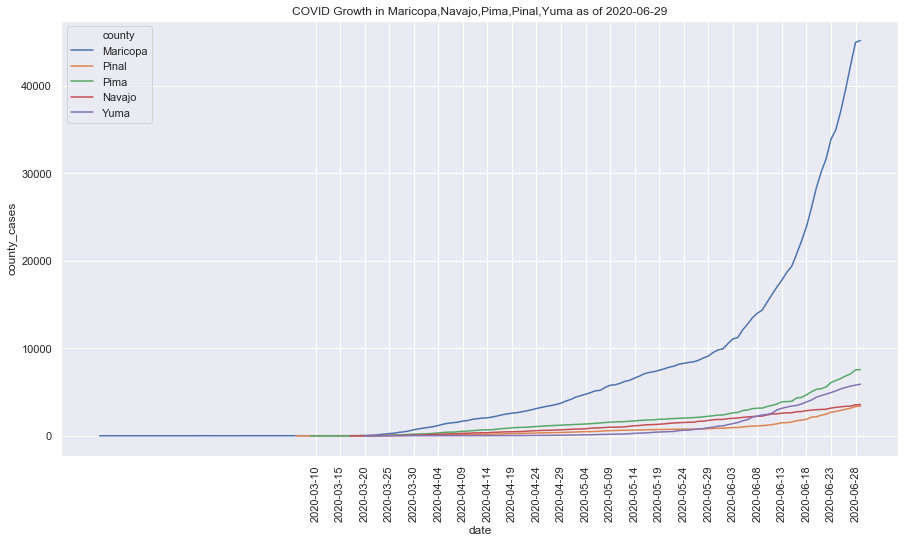

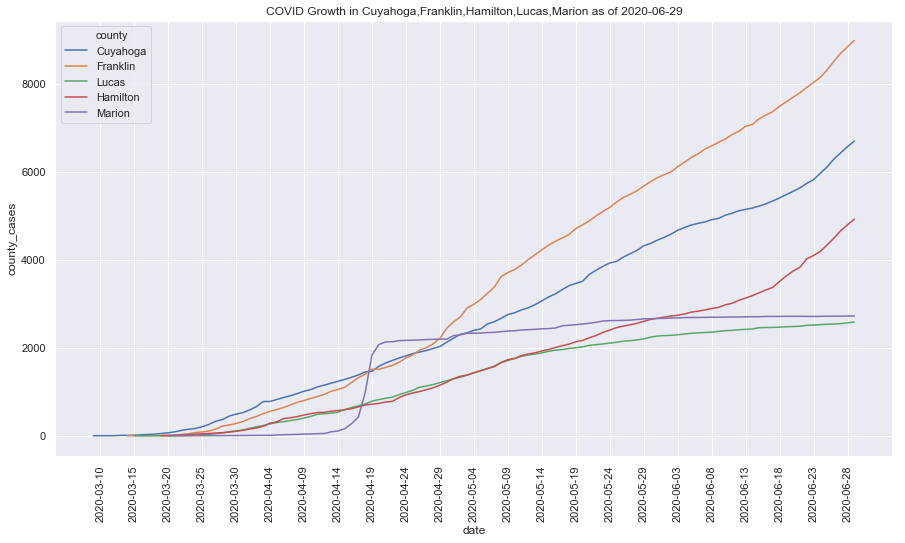

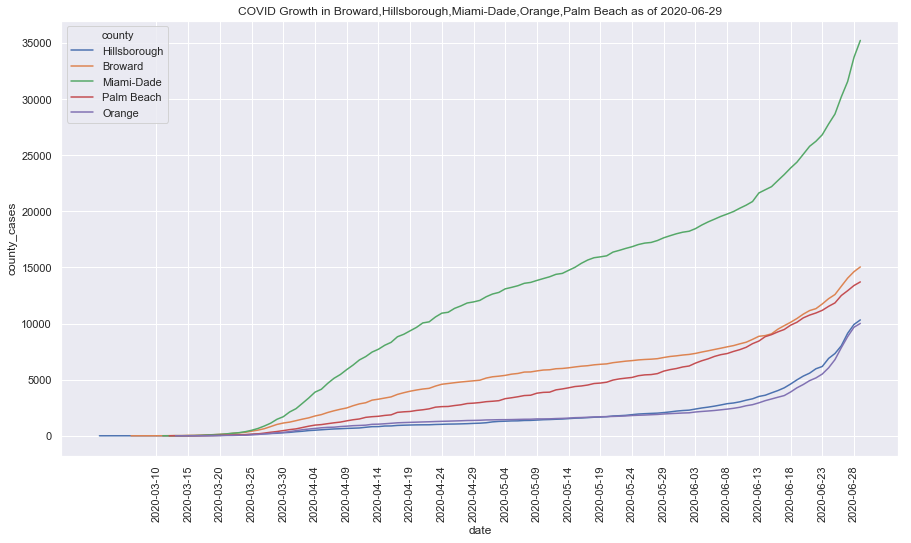

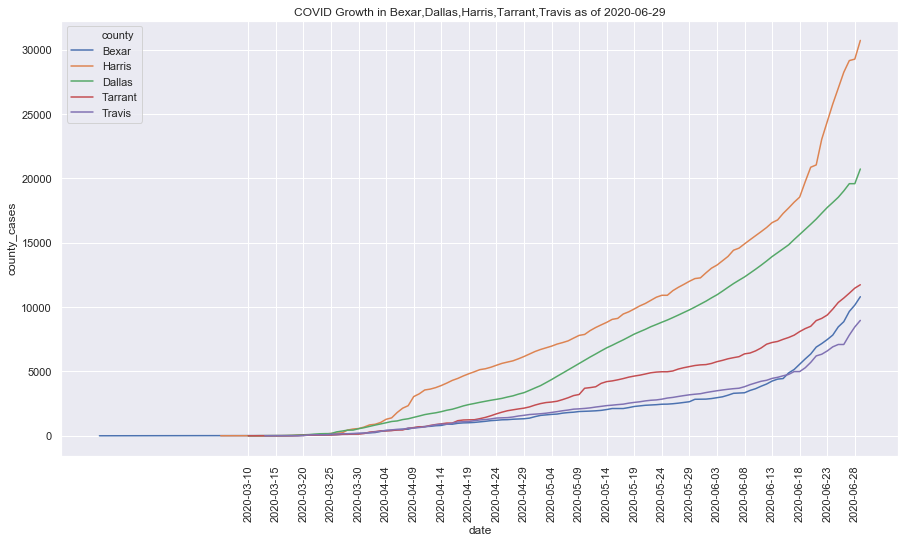

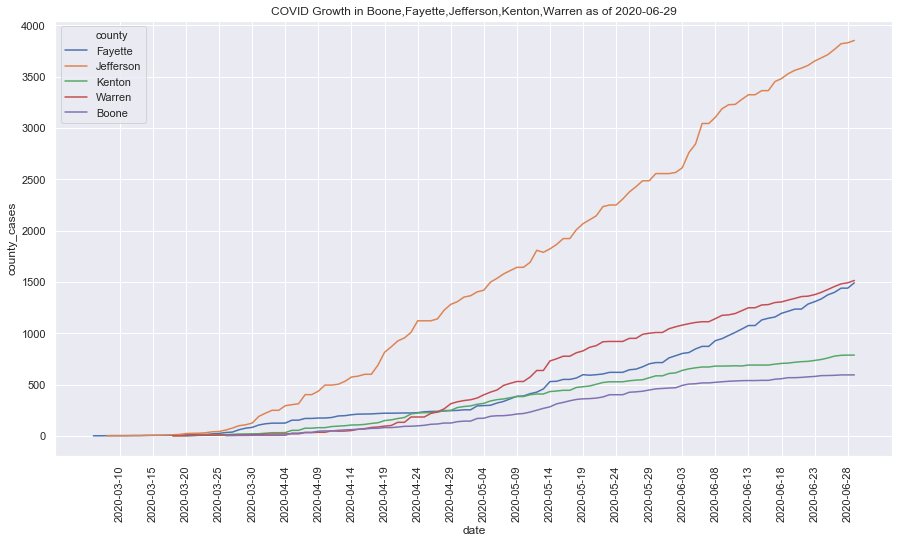

In [24]:
for state in ['Arizona', 'Ohio', 'Florida', 'Texas', 'Kentucky']: 
    plot_county(state = state,log = False, n = 5)

In [12]:
def new_st_cases(df, state, metricA, metricB):
    # filter to the state that you need
    needed_cols = ['date', 'state', 'state_cases', 'state_deaths']
    state_df = df.loc[df['state'] == state].drop_duplicates(subset = needed_cols)
    state_df = state_df[needed_cols]
    
    # get the number of new cases by day
    state_df['state_cases_yday'] = state_df['state_cases'].shift(1).fillna(0).astype(int)
    state_df['case_change'] = state_df['state_cases'] - state_df['state_cases_yday']
    state_df['pct_change_cases'] = (
        (state_df['state_cases'] - state_df['state_cases_yday']) / abs(state_df['state_cases_yday'])
    )
    
    # do the same for deaths
    state_df['state_deaths_yday'] = state_df['state_deaths'].shift(1).fillna(0).astype(int)
    state_df['deaths_change'] = state_df['state_deaths'] - state_df['state_deaths_yday']
    state_df['pct_change_deaths'] = (
        (state_df['state_deaths'] - state_df['state_deaths_yday']) / 
        abs(state_df['state_deaths_yday'])
    )
    
    state_df = state_df.loc[state_df['state_cases'] > state_df['state_cases'].max() * .25]
    
    # format the case and deaths df's in the right way
    
    case_df = state_df[['date', 'state', metricA]]
    case_df['number'] = case_df[metricA].fillna(0)
    case_df = case_df.drop(metricA, axis = 1)
    case_df['group'] = metricA

    death_df = state_df[['date', 'state', metricB]]
    death_df['number'] = death_df[metricB].fillna(0)
    death_df = death_df.drop(metricB, axis = 1)
    death_df['group'] = metricB
    
    return pd.concat([case_df, death_df], axis = 0, sort = True)

In [13]:
from pandas.plotting import register_matplotlib_converters
import matplotlib.pyplot as plt

register_matplotlib_converters()


def plot_states(states): 
    # get a list of states
    states = sorted(states)
    
    for state in states: 
        plot_df = new_st_cases(df, state = state, metricA = 'case_change', metricB = 'deaths_change')
        
        # get the state and end date for each state
        start_dt = plot_df['date'].min()
        end_dt = plot_df['date'].max()
        print('The max date for {} is {}'.format(state, end_dt.date()))
        
        plt.figure(figsize = (15,8))

        plot = sns.lineplot(
            x = 'date', 
            y = 'number',
            hue = 'group', 
            data = plot_df
        )
        
        dates = pd.date_range(start = start_dt, end = end_dt, freq = '5D').date
        plot.set_xticks(dates)
        plot.set_xticklabels(dates, rotation = 90)
        plot.set_title(label = 'COVID Growth in {} as of {}'.format(state, plot_df['date'].max().date()))
        plt.show(); 

The max date for Alabama is 2020-06-29


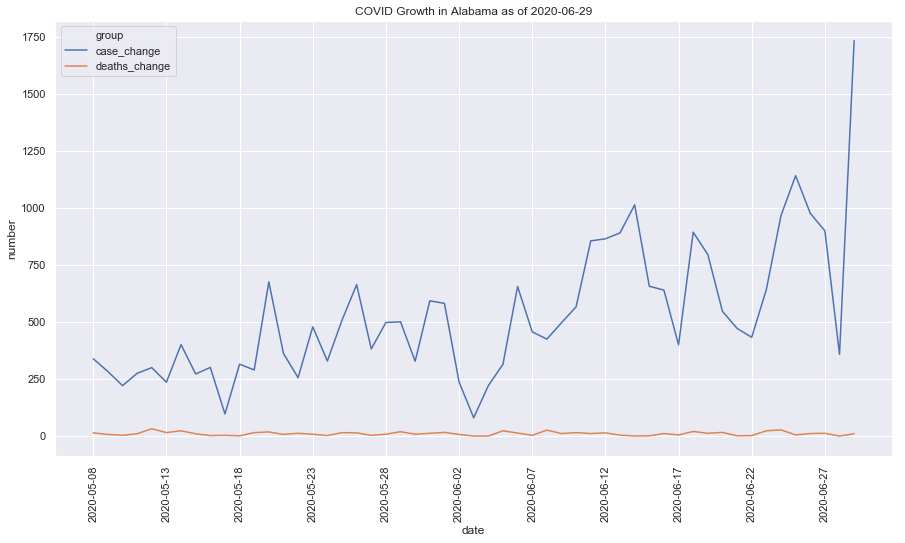

The max date for Arizona is 2020-06-29


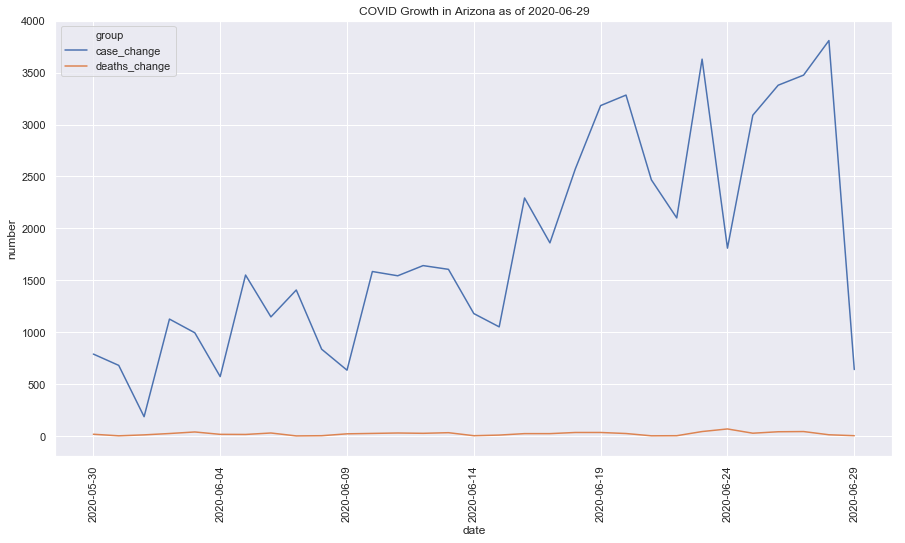

The max date for Arkansas is 2020-06-29


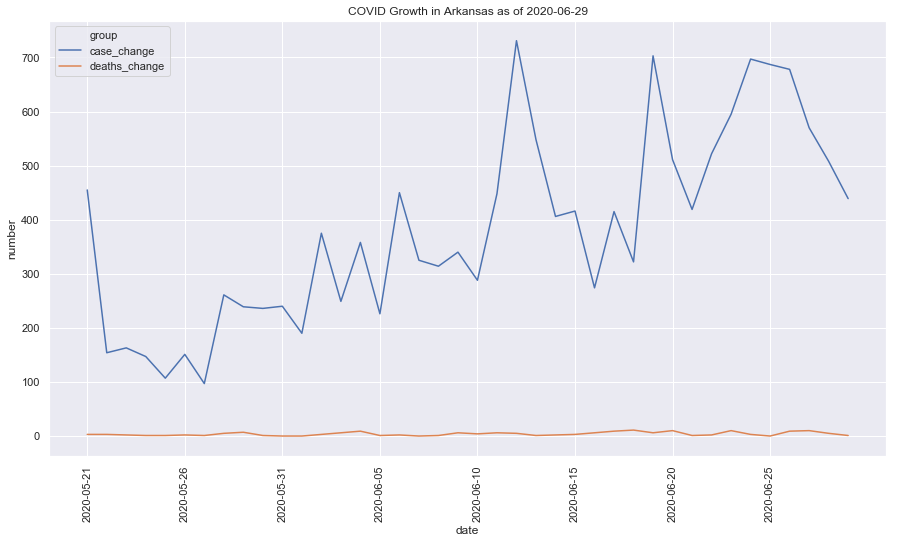

The max date for Florida is 2020-06-29


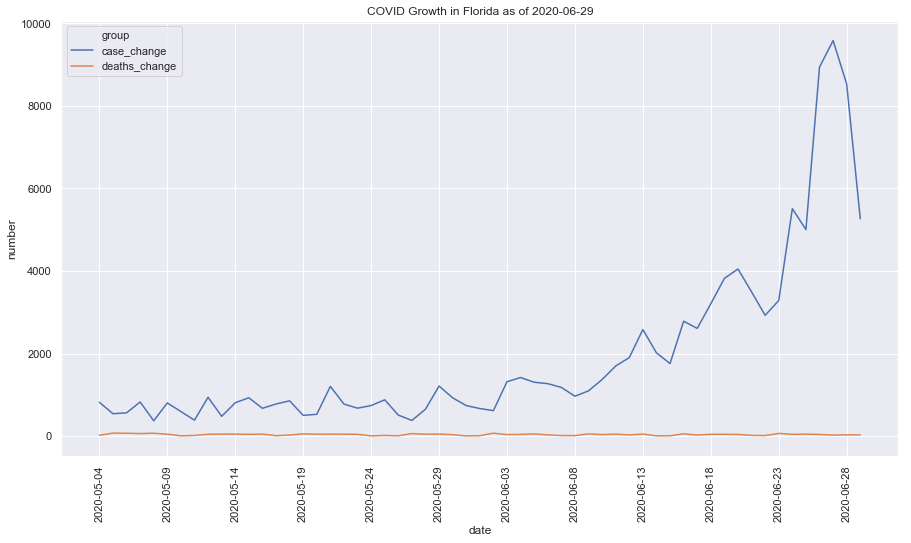

The max date for Kentucky is 2020-06-29


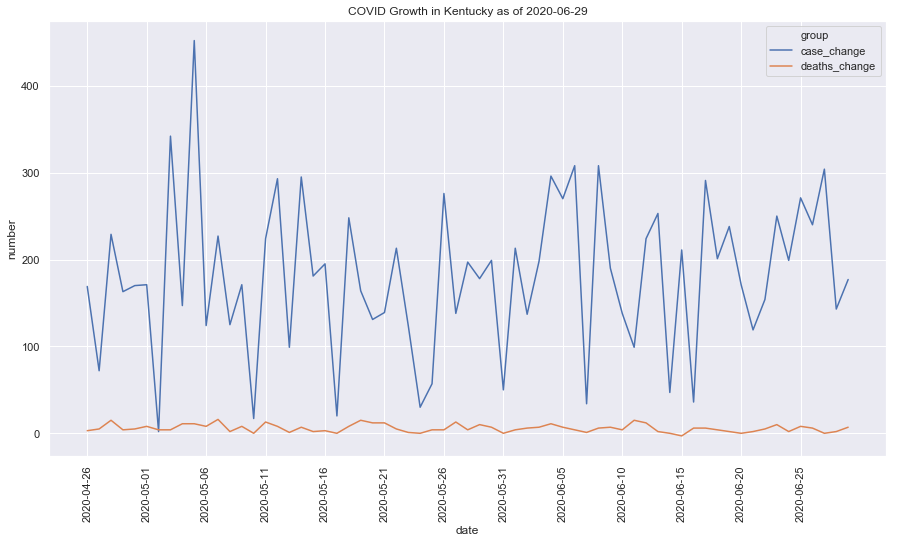

The max date for New York is 2020-06-29


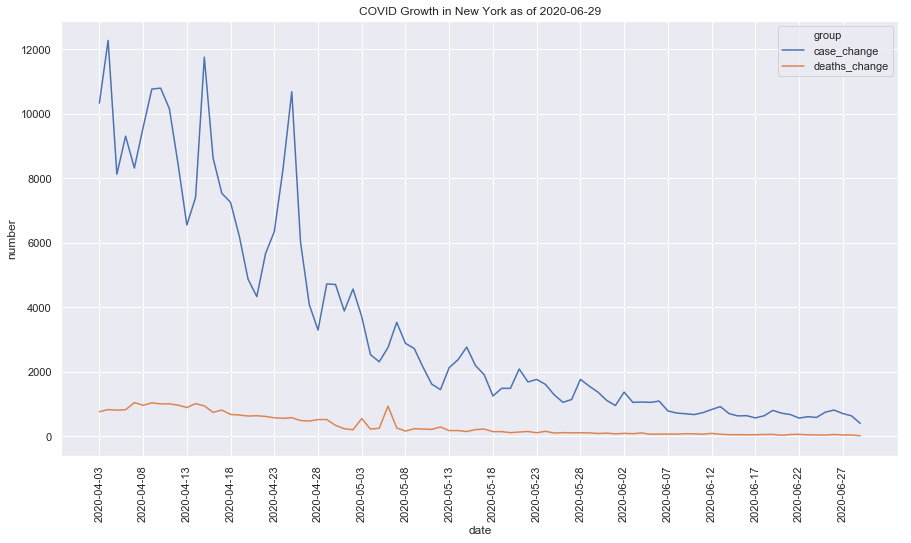

The max date for Ohio is 2020-06-29


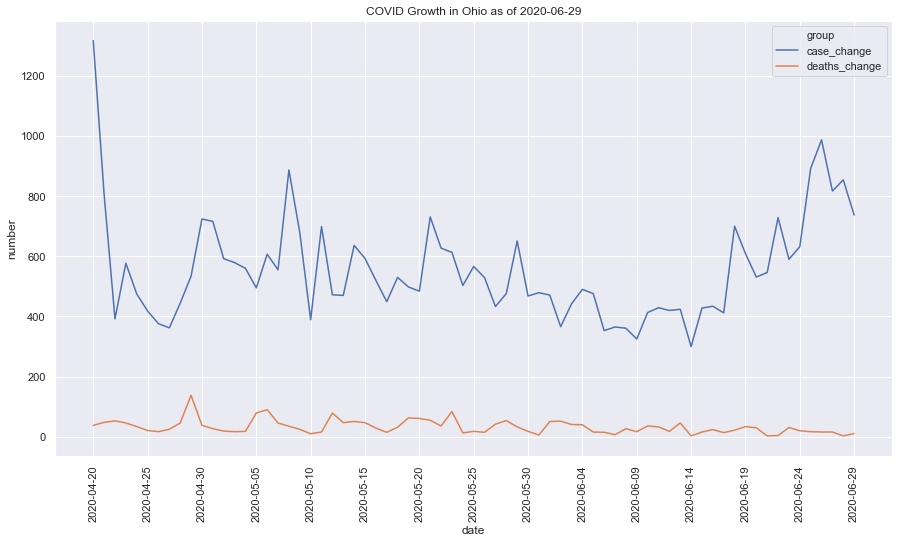

The max date for Oklahoma is 2020-06-29


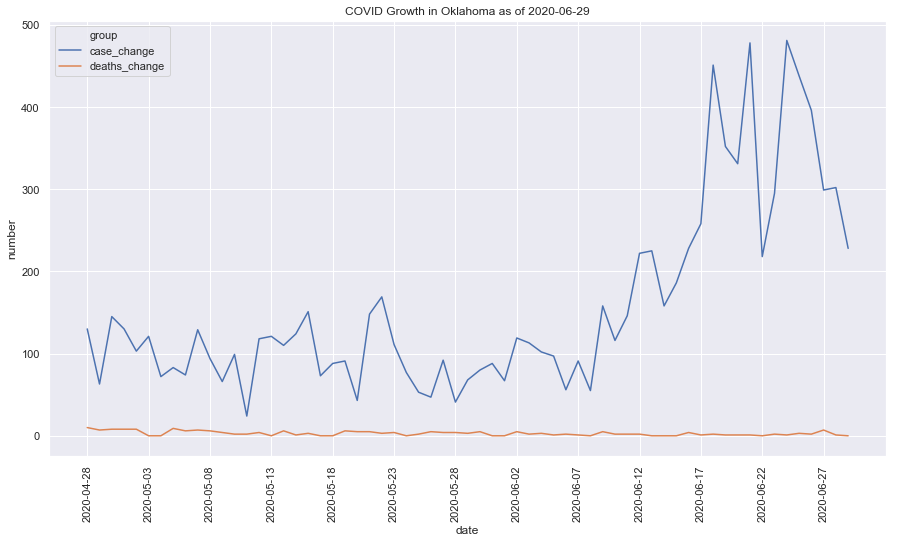

The max date for Texas is 2020-06-29


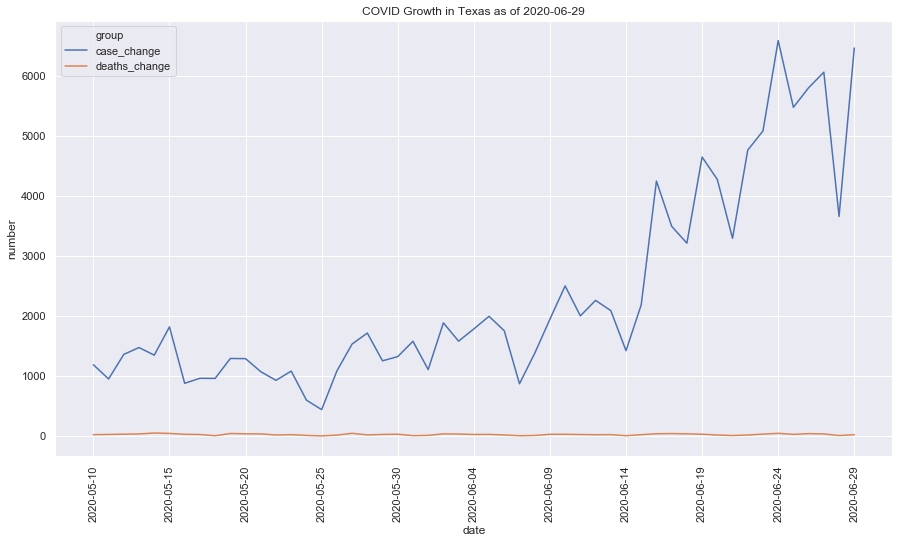

In [14]:
plot_states(states = [
    'Florida', 'Kentucky', 'New York', 'Arizona', 'Texas', 'Ohio', 
    'Alabama', 'Arkansas', 'Oklahoma'
])

In [15]:
from fbprophet import Prophet
import warnings
from datetime import timedelta
warnings.filterwarnings('ignore')

Importing plotly failed. Interactive plots will not work.


In [16]:
def create_model(df, state, metric, tt_split = 0.65): 
    print('-' * 53, state, '-' * 53)
    prophet = Prophet(daily_seasonality = True,
                      yearly_seasonality = False
                     )
    
    state_df = df.loc[df['state'] == state]
    state_df['state_cases_yday'] = state_df['state_cases'].shift(1).fillna(0).astype(int)
    state_df['case_change'] = state_df['state_cases'] - state_df['state_cases_yday']
    
    state_df = state_df.loc[state_df['state_cases'] > state_df['state_cases'].max() * .02]
    
    state_df = state_df[['date', metric]].rename(
        columns = {'date' : 'ds', metric : 'y'}
    ).drop_duplicates()
    
    n_days = int((state_df['ds'].max() - state_df['ds'].min()).days * tt_split)
    cutoff_date = state_df['ds'].min() + timedelta(days = n_days)
    
    train_df = state_df.loc[state_df['ds'] < cutoff_date.date()]
    test_df = state_df.loc[state_df['ds'] >= cutoff_date.date()]
    
    model = prophet.fit(train_df)
    forecast = model.predict(test_df)
    # fig = model.plot_components(forecast)
    
    forecast = forecast[['ds', 'yhat']].rename(columns = {'ds' : 'date', 'yhat' : 'predicted'})
    
    predicted = state_df.rename(
        columns = {'ds' : 'date', 'y' : metric}
    ).merge(
        right = forecast, 
        how = 'left', 
        on = ['date']
    ).dropna().drop_duplicates()
    

    
    actual = predicted[['date', metric]].rename(columns = {metric : 'number'})
    actual['marker'] = 'actual'

    forcasted = predicted[['date', 'predicted']].rename(columns = {'predicted' : 'number'})
    forcasted['marker'] = 'predicted'

    final_df = pd.concat([actual, forcasted], axis = 0, sort = False)
    
    return final_df

In [17]:
def plot_data(df, marking=None): 
    start_dt = df['date'].min()
    end_dt = df['date'].max()

    plt.figure(figsize=(15,8))


    forecast_plot = sns.lineplot(
        x = 'date', 
        y = 'number',
        hue = 'marker', 
        data = df
    )

    dates = pd.date_range(start=start_dt, end=end_dt, freq = '5D').date
    forecast_plot.set_xticks(dates)
    forecast_plot.set_xticklabels(dates, rotation = 90)
    forecast_plot.set_title(
        label = 'Predicted vs Actual COVID Growth in {marking}'.format(marking = marking)
    )
    plt.show(); 

In [18]:
def run_all(df, metric, states = None):
    if states is None: 
        states = sorted(set(df['state'].tolist()))
    for state in states:
        model_df = create_model(df = df, metric = metric, state = state)
        plot_data(df = model_df, marking = state)

----------------------------------------------------- Ohio -----------------------------------------------------


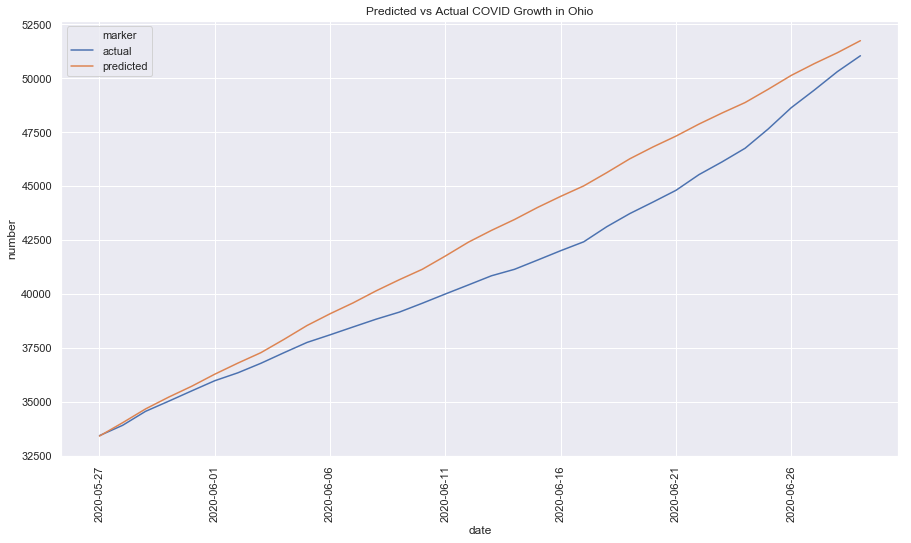

----------------------------------------------------- Texas -----------------------------------------------------


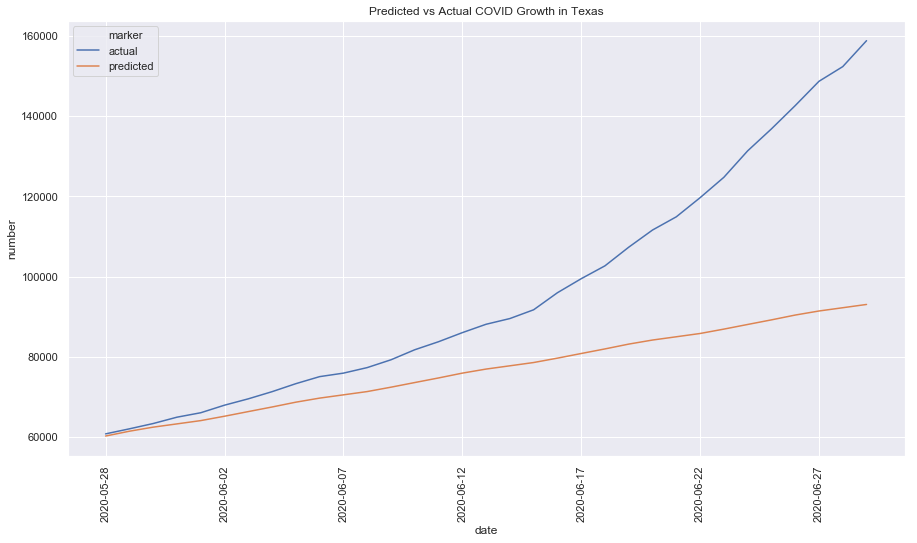

----------------------------------------------------- Arizona -----------------------------------------------------


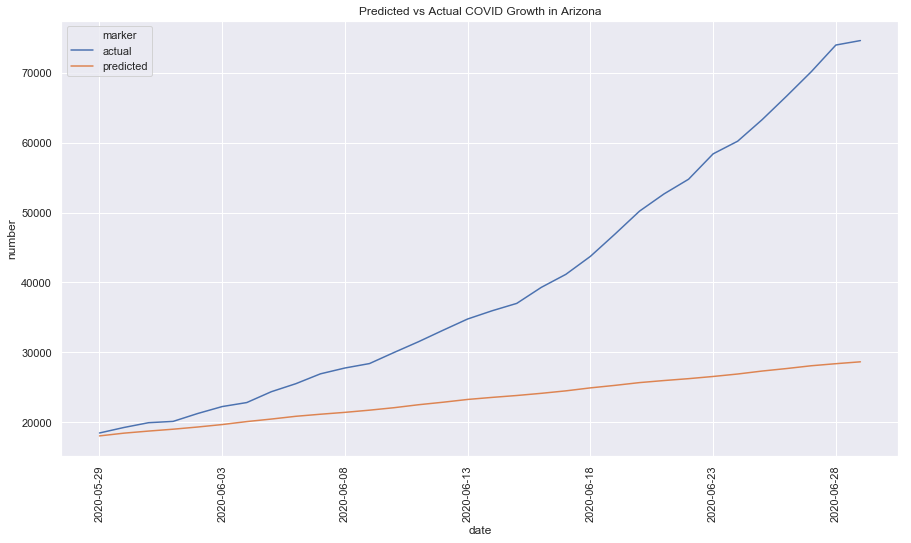

----------------------------------------------------- Kentucky -----------------------------------------------------


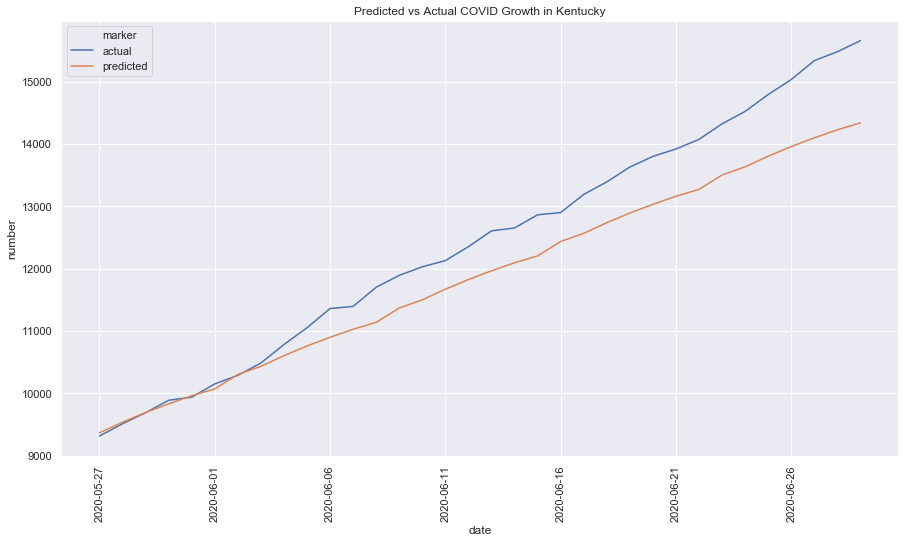

----------------------------------------------------- New York -----------------------------------------------------


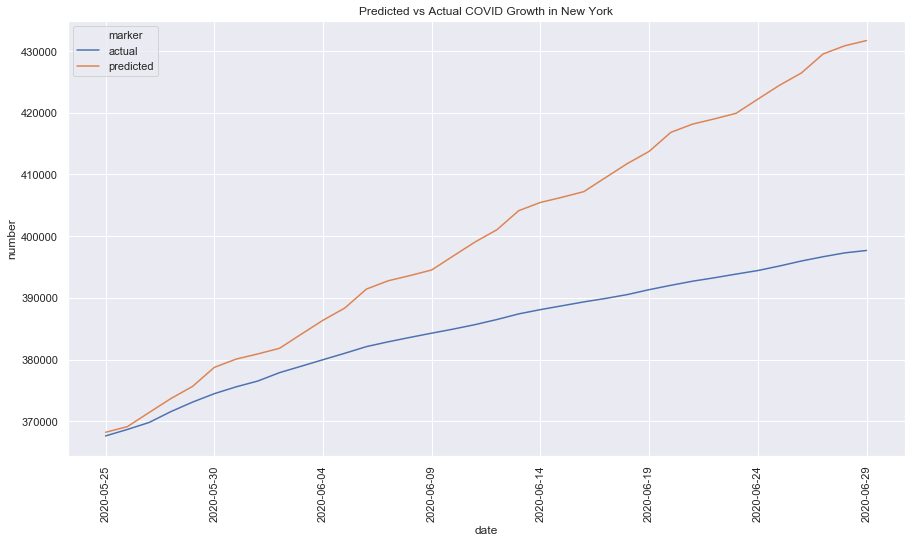

----------------------------------------------------- Indiana -----------------------------------------------------


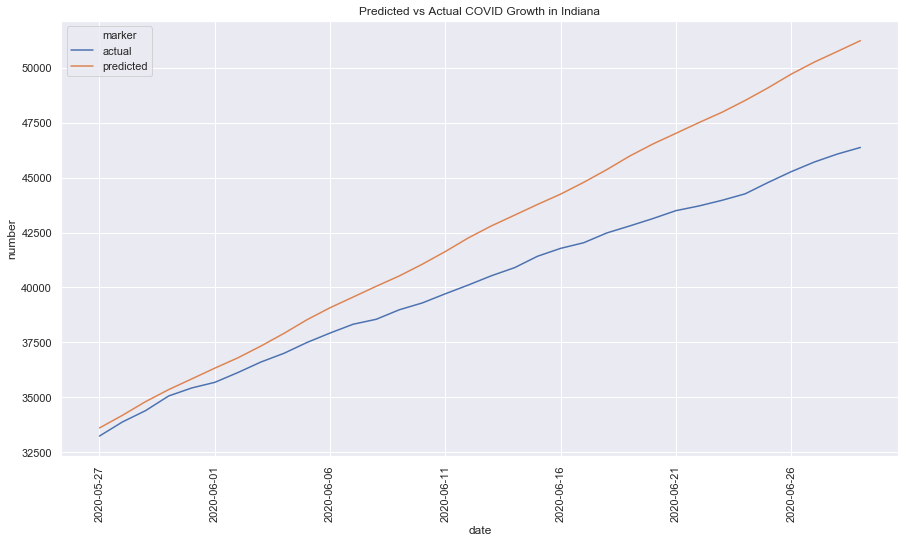

In [19]:
if __name__ == '__main__': 
    run_all(df = df, metric = 'state_cases', states = 
            ['Ohio', 'Texas', 'Arizona', 'Kentucky', 'New York', 'Indiana']
           )

In [20]:
def predict_county(df, state, county, tt_split): 
    prophet = Prophet(daily_seasonality = True,
                      yearly_seasonality = False
                     )
    
    county_df = df.loc[df['state'] == state].loc[df['county'] == county]
    
    county_df = county_df.loc[county_df['county_cases'] > county_df['county_cases'].max() * .02]
    
    county_df = county_df[['date', 'county_cases']].rename(
        columns = {'date' : 'ds', 'county_cases' : 'y'}
    ).drop_duplicates()
    
    n_days = int((county_df['ds'].max() - county_df['ds'].min()).days * tt_split)
    cutoff_date = county_df['ds'].min() + timedelta(days = n_days)
    
    train_df = county_df.loc[county_df['ds'] < cutoff_date.date()]
    test_df = county_df.loc[county_df['ds'] >= cutoff_date.date()]
    
    model = prophet.fit(train_df)
    forecast = model.predict(test_df)
    
    
    forecast = forecast[['ds', 'yhat']].rename(columns = {'ds' : 'date', 'yhat' : 'predicted'})
    
    predicted = county_df.rename(
        columns = {'ds' : 'date', 'y' : 'county_cases'}
    ).merge(
        right = forecast, 
        how = 'left', 
        on = ['date']
    ).dropna().drop_duplicates()
    

    
    actual = predicted[['date', 'county_cases']].rename(columns = {'county_cases' : 'number'})
    actual['marker'] = 'actual'

    forcasted = predicted[['date', 'predicted']].rename(columns = {'predicted' : 'number'})
    forcasted['marker'] = 'predicted'

    final_df = pd.concat([actual, forcasted], axis = 0, sort = False)
    
    return final_df

In [21]:
def run_all_counties(state, counties=None): 
    state_df = df.loc[df['state'] == state]
    if counties is None: 
        counties = sorted(set(state_df['county'].tolist()))
    
    for county in counties: 
        county_df = predict_county(
            df = df, 
            state = state, 
            county = county, 
            tt_split = 0.65
        )
    
        plot_data(df = county_df, marking=county)

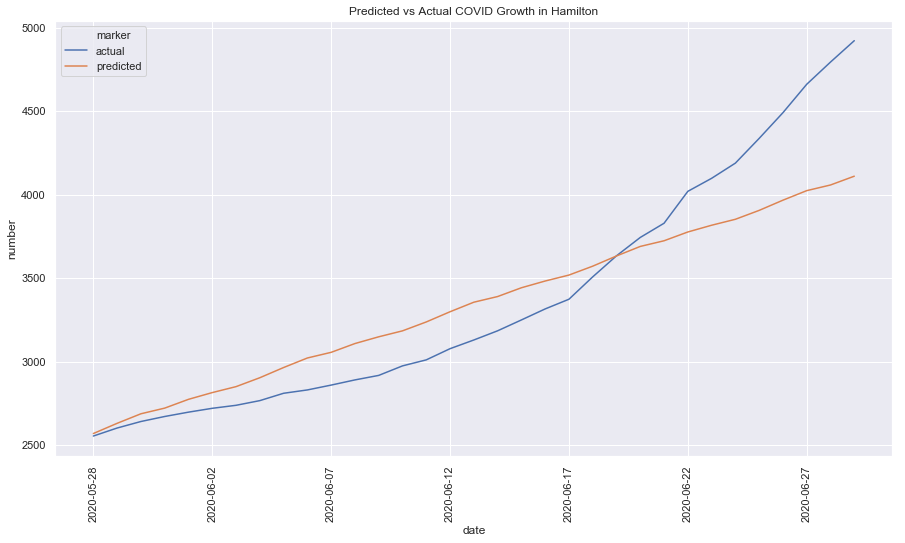

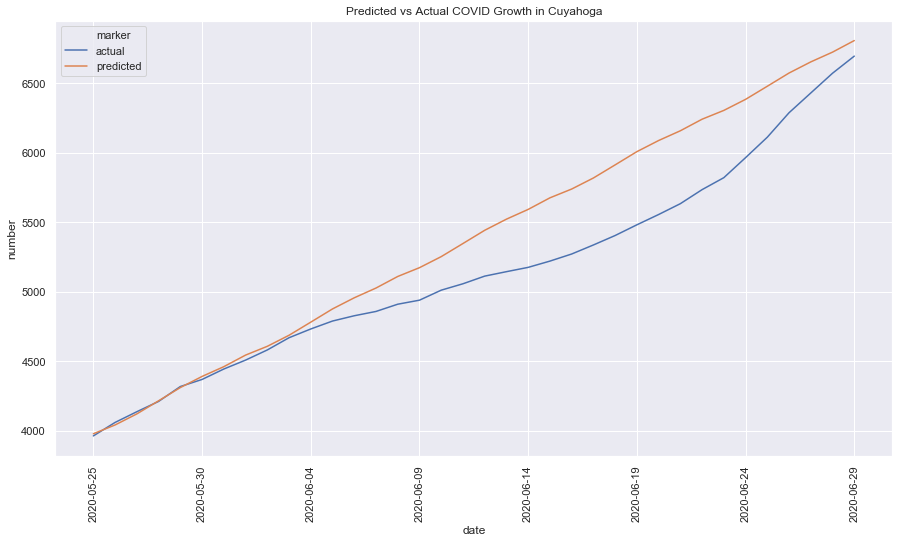

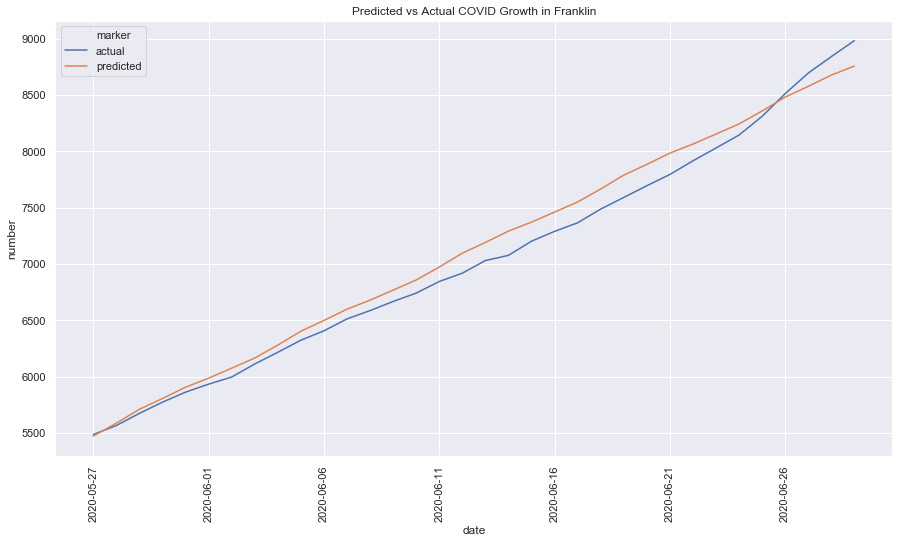

In [22]:
run_all_counties('Ohio', 
                 counties = ['Hamilton', 'Cuyahoga', 'Franklin']
                )